### Housekeeping

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from Settings import columns, experiments
import Pipeline
import matplotlib.pyplot as plt

In [4]:
current_exp = experiments['all']

pipeline = Pipeline.DataClean(columns, current_exp)
pipeline.clean_data()
pipeline.norm()
pipeline.split_label()
pipeline.train_val()  

i made it to train val
imade it to else statement


Look into just using environmental variable instead of using the previous persistence of solar IR

In [5]:
pipeline.floatcols

Index(['Global CMP22 (vent/cor) [W/m^2]', 'Tower Wet Bulb Temp [deg C]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')

# Model Creation

#### Model Hyperparameters

In [ ]:
SEED = 26

HIDDENS = [3,3]
ACTIVATIONS = ['relu'] * len(HIDDENS)


# optional
NUM_EPOCHS = 300
BATCH_SIZE = 256
VERBOSITY = 0
LEARNING_RATE = 0.0001
LOSS = keras.losses.MeanSquaredError()

# Early stopping
EARLY_STOPPING = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=20,
                                              mode='auto',
                                              restor_best_weights=True)

# setting sead
try:
    tf.random.set_seed(SEED)
escept:
    tf.set_random_seed(SEED)

### Skeleton
Below is creating the "skeleton" of the model. It does not need any specific data, only the shape and what it will do

Using the functional API method

In [43]:
inputs = keras.Input(shape=(pipeline.xtrain[0].shape))

x = keras.layers.Dense(64, activation=current_exp['activation'])(inputs)

x = keras.layers.Dense(64, activation=current_exp['activation'])(x)

outputs = keras.layers.Dense(12)(x)


model = keras.Model(inputs=inputs, outputs=outputs, name='SolarNN')

model.summary()

Model: "SolarNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1680)]            0         
                                                                 
 dense_17 (Dense)            (None, 64)                107584    
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 12)                780       
                                                                 
Total params: 112,524
Trainable params: 112,524
Non-trainable params: 0
_________________________________________________________________


In [27]:
# First we start with an input layer
input_layer = keras.layers.Input(shape=(pipeline.xtrain[0].shape,)) # size per sample, equal to number of features

# Dropout may be useful for hidden layers if the number of hidden nodes is large
# Let's apply dropout to the input layer. (If Dropout(0), Dropout isn't being used)
layers = keras.layers.Dropout(0.004)(input_layer)

layers = keras.layers.Dense(100, activation='relu',
               bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
               kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)

layers = keras.layers.Dropout(0)(layers)

# Output layer has a softmax function to convert output to class likelihood
output_layer = keras.layers.Dense(pipeline.ytrain[0].shape[0], activation='softmax',
                  bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                  kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)



# model.add(keras.layers.Dense(300, activation=current_exp['activation']))
# model.add(keras.layers.Dense(100, activation=current_exp['activation']))
# model.add(keras.layers.Dense(10, activation=current_exp['activation']))

# Similarly 
# model = keras.models.Sequential([
#     keras.layers.Flaten(input_shape=[180,17]),
#     keras.layers.Dense(300, activation=current_exp['activation']),
#     keras.layers.Dense(100, activation=current_exp['activation']),
#     keras.layers.Dense(10, activation=current_exp['activation']),
# ])

model= keras.Model(input_layer, output_layer)

In [38]:
np.shape(layers)


TensorShape([None, 100])

### The shapes are incompatible because last shape output is 10 and it should be 120???

Tensorflow.data
I can batch things?? Batch train. 

In [28]:
model.summary()
# hidden1 = model.layers[1]
# weights,biases = hidden1.get_weights()
# weights  # weights randomly initialized

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1680)]            0         
                                                                 
 dropout_5 (Dropout)         (None, 1680)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               168100    
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                1212      
                                                                 
Total params: 169,312
Trainable params: 169,312
Non-trainable params: 0
_________________________________________________________________


### Compile model


In [44]:
model.compile(loss=keras.losses.MeanSquaredError(),
             optimizer='sgd',
             metrics=['accuracy'])

### Training the model

In [45]:
history = model.fit(pipeline.xtrain, pipeline.ytrain, epochs=5, validation_data=[pipeline.xval, pipeline.yval])

Epoch 1/5
6723/6723 [==============================] - 31s 5ms/step - loss: nan - accuracy: 0.2477 - val_loss: nan - val_accuracy: 0.4168
Epoch 2/5
6723/6723 [==============================] - 25s 4ms/step - loss: nan - accuracy: 0.2478 - val_loss: nan - val_accuracy: 0.4168
Epoch 3/5
6723/6723 [==============================] - 23s 3ms/step - loss: nan - accuracy: 0.2478 - val_loss: nan - val_accuracy: 0.4168
Epoch 4/5
6723/6723 [==============================] - 20s 3ms/step - loss: nan - accuracy: 0.2478 - val_loss: nan - val_accuracy: 0.4168
Epoch 5/5
6723/6723 [==============================] - 20s 3ms/step - loss: nan - accuracy: 0.2478 - val_loss: nan - val_accuracy: 0.4168


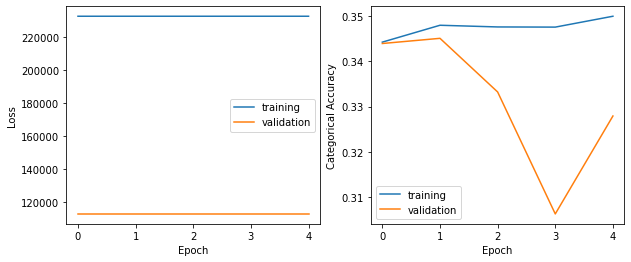

In [31]:
# Let's plot the change in loss and accuracy

fig, axs = plt.subplots(1, 2, figsize = (10,4))

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='training')
axs[1].plot(history.history['val_accuracy'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Categorical Accuracy')
axs[1].legend();

<AxesSubplot:>

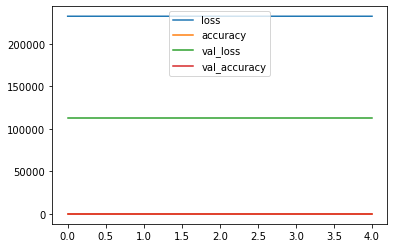

In [32]:
pd.DataFrame(history.history).plot()